In [1]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time


from agent import Agent
from torch.autograd import Variable

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/pytho

In [2]:
BATCH_SIZE = 32
LEARING_RATE = 0.0001

gamma = 0.99
max_num_episodes = 1000
hidden_size = 128
min_epsilon = 0.01
max_eps_episodes = 50

print_every = 10

In [3]:
env = gym.make('LunarLander-v3', continuous=False, gravity=-10.0, enable_wind=False, 
               wind_power=15.0, turbulence_power=1.5)

space_size = env.observation_space.shape[0]
action_size = env.action_space.n

threshold = env.spec.reward_threshold

agent = Agent(space_size, action_size, hidden_size, LEARING_RATE)

In [4]:
def linear_epsilon_decay(episode) -> float:
    """Linear decrease in 𝜖, whereby the value decreases evenly as the episode increases.
    
    Args:
        episode (int): The current episode number.
        
    Returns:
        float: The 𝜖 value for the current episode.
    """
    slope = (min_epsilon - 1.0) / max_eps_episodes
    return max(min_epsilon, slope * episode + 1.0)

In [5]:
def exponential_epsilon_decay(episode):
    """Exponential decrease in 𝜖. Initially, 𝜖 falls rapidly and then asymptotically approaches min_epsilon.
    
    Args:
        episode (int): The current episode number.
        
    Returns:
        float: The 𝜖 value for the current episode.
    """
    return min_epsilon + (1.0 - min_epsilon) * np.exp(-1.0 * episode / max_eps_episodes)

In [6]:
def run_episode(env, agent, eps):
    """Run a single episode of the environment and train the agent.
    
    Args:
        env (gym.Env): The environment to run.
        agent (Agent): The agent to use.
        eps (float): The epsilon value to use for the episode.
        
    Returns:
        float: The total reward for the episode.
    """
    state = env.reset()[0]
    done = False
    total_reward = 0
    
    while not done:
        action = agent.get_action(FloatTensor([state]), eps)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        total_reward += reward
        
        done = terminated or truncated
        
        if done:
            reward = -1
            
        agent.learn(
            FloatTensor([state]), 
            action, 
            FloatTensor([reward]), 
            FloatTensor([next_state]), 
            FloatTensor([done]), 
            gamma)
            
        state = next_state
        
    return total_reward

In [7]:
def train_agent(env, agent, max_num_episodes, print_every, threshold, epsilon_decay_fn):
    scores_array = []
    avg_scores_array = []
    cumulative_score = 0
    
    time_start = time.time()
    
    for episode in range(max_num_episodes):
        eps = epsilon_decay_fn(episode)
        
        score = run_episode(env, agent, eps)
        scores_array.append(score)
        cumulative_score += score
        avg_score = cumulative_score /len(scores_array)
        avg_scores_array.append(avg_score)
        
        if episode % print_every == 0 and episode > 0:
            dt = int(time.time() - time_start)
            print(f"Episode {episode} - Score: {score} - Avg Score: {avg_score:.2f} - Epsilon: {eps:.4f} - Time: {dt}s")
            
        if avg_score >= threshold:
            print(f"Environment solved in {episode} episodes with an average score of {avg_score:.2f}!")
            break
        
    return scores_array, avg_scores_array

In [8]:
scores, avg_scores = train_agent(env, agent, max_num_episodes, print_every, threshold, exponential_epsilon_decay)

Episode 10 - Score: -414.0365866267602 - Avg Score: -154.25 - Epsilon: 0.8205 - Time: 1s
Episode 20 - Score: -535.093325261171 - Avg Score: -216.02 - Epsilon: 0.6736 - Time: 3s
Episode 30 - Score: -229.3368381530576 - Avg Score: -265.20 - Epsilon: 0.5533 - Time: 6s
Episode 40 - Score: -385.78558888244305 - Avg Score: -288.02 - Epsilon: 0.4548 - Time: 9s
Episode 50 - Score: -674.4231941693965 - Avg Score: -331.39 - Epsilon: 0.3742 - Time: 12s
Episode 60 - Score: -453.50751055051177 - Avg Score: -361.82 - Epsilon: 0.3082 - Time: 14s
Episode 70 - Score: -218.6931073549196 - Avg Score: -382.34 - Epsilon: 0.2541 - Time: 18s
Episode 80 - Score: -708.9676212562692 - Avg Score: -406.03 - Epsilon: 0.2099 - Time: 21s
Episode 90 - Score: -648.2797162368464 - Avg Score: -420.87 - Epsilon: 0.1736 - Time: 24s
Episode 100 - Score: -618.8061234758079 - Avg Score: -433.91 - Epsilon: 0.1440 - Time: 29s
Episode 110 - Score: -122.82406846906179 - Avg Score: -438.80 - Epsilon: 0.1197 - Time: 36s
Episode 12

Length of scores: 1000. Length of avg_scores: 1000


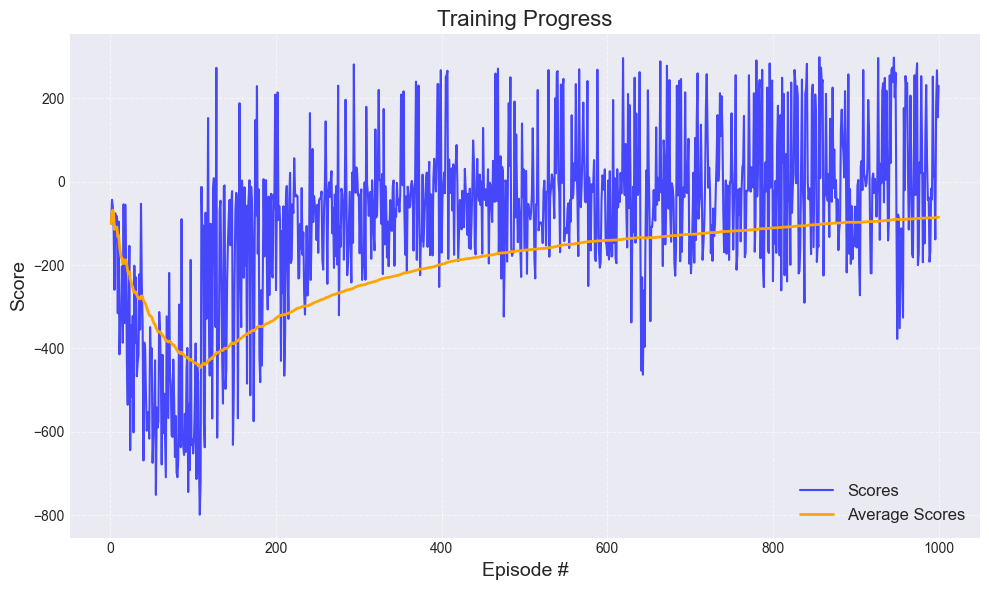

In [9]:
print(f"Length of scores: {len(scores)}. Length of avg_scores: {len(avg_scores)}")

plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(1, len(scores) + 1), scores, label="Scores", color="blue", alpha=0.7)
ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label="Average Scores", color="orange", linewidth=2)

ax.set_title("Training Progress", fontsize=16)
ax.set_xlabel("Episode #", fontsize=14)
ax.set_ylabel("Score", fontsize=14)

ax.legend(loc="best", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
asd

In [10]:
def watch_agent(env, agent, max_episodes=5):
    state = env.reset()[0]
    done = False
    total_reward = 0
    
    for episode in range(max_episodes):
        env.render()
        action = agent.get_action(FloatTensor([state]), 0.0)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        
        total_reward += reward
        state = next_state
        
        done = terminated or truncated
        if done:
            break
        
    env.close()
    print(f"Total reward: {total_reward}")